<a href="https://colab.research.google.com/github/valy3124/ML-Labs/blob/main/ga_knapsack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducere in Algoritmi Genetici

### Obiective
- Implementarea ciclului de bază a procedurii de căutare a unei soluții optime prin evoluția unei populașii de indivizi ale căror proprietăți (gene) codifică spațiul de valori posibile ale soluțiilor
- Definirea unei funcții de fitness
- Implementarea operatorilor genetici de selecție, crossover, mutație
- Implementarea procedurii de evoluție a unei generații
- Testarea și analiza performanței unui algoritm genetic pe o problema simplă: **problema rucsacului 0/1**


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import random
from dataclasses import dataclass
from collections import defaultdict

In [9]:
@dataclass
class KnapsackProblem:
    max_weight: int
    values: List[int]
    weights: List[int]

def parse_input_from_file(file_path: str) -> KnapsackProblem:
    with open(file_path, "r") as file:
        lines = file.read().strip().split('\n')
        max_weight = int(lines[0])
        values = [int(x.strip()) for x in lines[1].split(',')]
        weights = [int(x.strip()) for x in lines[2].split(',')]
        return KnapsackProblem(max_weight, values, weights)

### Implementarea soluției optime folosind programare dinamică

In [10]:
def knapsack_dp(problem: KnapsackProblem) -> int:
    """
    Rezolvăm 0/1 knapsack problem folosind programare dinamică.

    Parameterii:
    problem (KnapsackProblem): Instanța de problemă de rezolvat

    Ieșiri:
    int: Valoarea maximă care poate fi obținută
    """
    n = len(problem.values)
    dp = [[0] * (problem.max_weight + 1) for _ in range(n + 1)]

    for i in range(1, n + 1):
        for w in range(1, problem.max_weight + 1):
            if problem.weights[i - 1] > w:
                dp[i][w] = dp[i - 1][w]
            else:
                dp[i][w] = max(dp[i - 1][w], problem.values[i - 1] + dp[i - 1][w - problem.weights[i - 1]])

    return dp[n][problem.max_weight]

### Implementarea algoritmului genetic

In [11]:
class GeneticAlgorithm:
    def __init__(
        self,
        problem: KnapsackProblem,
        population_size: int,
        tournament_size: int,
        mutation_rate: float,
        fitness_option: int,
        max_generations: int
    ):
        self.problem = problem
        self.population_size = population_size
        self.tournament_size = tournament_size
        self.mutation_rate = mutation_rate
        self.fitness_option = fitness_option
        self.max_generations = max_generations
        self.chromosome_length = len(problem.values)

        # Menținere statistici
        self.max_fitness_history = []
        self.unique_individuals_history = []

        # Initializare populatie
        self.population = self._initialize_population()

    def _initialize_population(self) -> np.ndarray:
        """Initialiazare aleatoare a populatiei de indivizi cu cromozomi avand gene binare"""
        return np.random.randint(2, size=(self.population_size, self.chromosome_length))

    def _calculate_fitness(self, individual: np.ndarray) -> float:
      """
      Calculul fitnesului in functie de optiunea self.fitness_option.
        - Pentru fitness_option=1 se va intoarce 0 atunci cand suma greutatilor obiectelor depaseste
          greutatea maxim acceptabila
        - Pentru fitness_option=2 se va intoarce suma valorilor primelor k obiecte a caror greutate
          cumulata nu depaseste greutatea maxim acceptabila
      """
      total_value = 0
      total_weight = 0
      for i in range(len(individual)):
          if individual[i] == 1:  # If item is selected
              total_value += self.problem.values[i]
              total_weight += self.problem.weights[i]
              if total_weight > self.problem.max_weight:  # Check weight constraint
                  if self.fitness_option == 1:
                      return 0  # Return 0 if weight exceeds limit (option 1)
                  else:
                      break  # Stop adding items if weight exceeds limit (option 2)
      return total_value

    def _tournament_selection(self, population: np.ndarray) -> np.ndarray:
      """
      Implementati selectia de tip turneu, cu dimensiunea turneului data de self.tournament_size.
      Procedura trebuie sa faca o selectie de dimensiune egala cu 50% din totalul populatiei.
      La fiecare pas se aleg aleator `self.tournament_size` indivizi din populatie, iar cel cu
      fitness-ul maxim este selectat in noua generatie.
      """
      selected = []
      for _ in range(self.population_size // 2):  # Select 50% of the population
          tournament = random.sample(list(population), self.tournament_size)  # Randomly select individuals for the tournament
          best_individual = max(tournament, key=self._calculate_fitness)  # Select the individual with the highest fitness
          selected.append(best_individual)  # Add the best individual to the selected group
      return np.array(selected)

    def _single_point_crossover(self, parent1: np.ndarray, parent2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
      """
      Implementati metoda de single-point crossover.
      Se alege aleator un punct de taiere in cromozomul ambilor parinti. Se interschimba jumatatile
      secundare ale cromozomilor indivizilor.
      """
      crossover_point = random.randint(1, self.chromosome_length - 1)  # Randomly select a crossover point
      child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))  # Create child 1
      child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))  # Create child 2
      return child1, child2

    def _bit_flip_mutation(self, individual: np.ndarray) -> np.ndarray:
        """
        Implementati mutatia bit-flip, avand aceeasi probabilitate de mutatie (self.mutation_rate)
        pentru fiecare gena din cromozomul individului.
        """
        for i in range(len(individual)):
            if random.random() < self.mutation_rate:  # Check if mutation should occur
                individual[i] = 1 - individual[i]  # Flip the bit (0 to 1 or 1 to 0)
        return individual

    def _get_population_stats(self) -> Tuple[float, float]:
        """
        Calcul al statisticilor per populatie:
          - cea mai mare valoare de fitness a unui individ din populatie
          - numarul de indivizi unici (cu cromozomi diferiti) din populatie
        """
        fitness_values = [self._calculate_fitness(ind) for ind in self.population]
        max_fitness = max(fitness_values)

        # Count unique individuals
        unique_individuals = len(set(tuple(ind) for ind in self.population))
        unique_individuals_percentage = unique_individuals / self.population_size

        return max_fitness, unique_individuals_percentage

    def run(self) -> Tuple[List[float], List[int]]:
        """
        Procedura de evolutie a algoritmului genetic de la populatie la populatie.
        """
        for generation in range(self.max_generations):
            # Aplicam selectia turneu, selectand 50% din indivizi care trec de la o generatie la alta
            selected = self._tournament_selection(self.population)

            # Aplicam metoda de crossover pentru a obtine indivizii "copii" care se adauga generatiei pana
            # la dimensiunea data a populatiei
            offspring = []
            while len(offspring) < self.population_size - len(selected):
                p1, p2 = random.sample(list(selected), 2)
                c1, c2 = self._single_point_crossover(p1, p2)
                offspring.extend([c1, c2])
            offspring = np.array(offspring[:self.population_size - len(selected)])

            # Obtinem populatia noua
            self.population = np.vstack((selected, offspring))

            # Aplicam mutatia fiecarui individ din populatia noua
            for i in range(len(self.population)):
                self.population[i] = self._bit_flip_mutation(self.population[i])

            # Mentinem statistici ale populatiei pentru vizualizari
            max_fitness, unique_count = self._get_population_stats()
            self.max_fitness_history.append(max_fitness)
            self.unique_individuals_history.append(unique_count)

        return self.max_fitness_history, self.unique_individuals_history

### Metode de rulare a experimentelor si de afisare a rezultatelor

In [12]:
def run_experiment(problem: KnapsackProblem):
    # Configuration options
    population_sizes = [100, 500]
    tournament_sizes = [3, 10]
    max_generations_options = [200]
    fitness_options = [1, 2]
    mutation_rate = 0.01

    results = defaultdict(list)

    # Run experiments with different configurations
    for pop_size in population_sizes:
        for tournament_size in tournament_sizes:
            for max_gens in max_generations_options:
                for fitness_opt in fitness_options:
                    print(f"Running: Pop={pop_size}, Tournament={tournament_size}, "
                          f"MaxGen={max_gens}, FitnessOpt={fitness_opt}")

                    ga = GeneticAlgorithm(
                        problem=problem,
                        population_size=pop_size,
                        tournament_size=tournament_size,
                        mutation_rate=mutation_rate,
                        fitness_option=fitness_opt,
                        max_generations=max_gens
                    )

                    max_fitness_history, unique_individuals_history = ga.run()

                    config = (pop_size, tournament_size, max_gens, fitness_opt)
                    results[config] = (max_fitness_history, unique_individuals_history)

    return results

In [13]:
def plot_results(results: dict, max_value: int):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # Plot maximum fitness
    ax1.set_title('Maximum Fitness per Generation')
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Maximum Fitness')

    # Plot unique individuals
    ax2.set_title('Unique Individuals per Generation')
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Number of Unique Individuals')

    colors = plt.cm.rainbow(np.linspace(0, 1, len(results)))

    ax1.axhline(y=max_value, color="black", linestyle='--', label=f'Optimal Value ({max_value})')

    legend_handles = []
    legend_labels = []

    for (pop_size, tournament_size, max_gens, fitness_opt), color in zip(results.keys(), colors):
        label = f'Pop={pop_size}, Tour={tournament_size}, MaxGen={max_gens}, Fit={fitness_opt}'
        max_fitness_history, unique_individuals_history = results[(pop_size, tournament_size, max_gens, fitness_opt)]

        # Add the maximum value achieved as a label at the end of the curve
        best_pop_value = max(max_fitness_history)
        print("Best config for " + label + f": {best_pop_value}\n")

        line, = ax1.plot(max_fitness_history, color=color, label=label, alpha=0.7)
        best_pop_value_label = f"Best Pop. Value: {best_pop_value:.2f}"
        legend_handles.append(line)
        legend_labels.append(best_pop_value_label)

        ax2.plot(unique_individuals_history, color=color, label=label, alpha=0.7)

    ax1.legend(legend_handles, legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

Running: Pop=100, Tournament=3, MaxGen=200, FitnessOpt=1
Running: Pop=100, Tournament=3, MaxGen=200, FitnessOpt=2
Running: Pop=100, Tournament=10, MaxGen=200, FitnessOpt=1
Running: Pop=100, Tournament=10, MaxGen=200, FitnessOpt=2
Running: Pop=500, Tournament=3, MaxGen=200, FitnessOpt=1
Running: Pop=500, Tournament=3, MaxGen=200, FitnessOpt=2
Running: Pop=500, Tournament=10, MaxGen=200, FitnessOpt=1
Running: Pop=500, Tournament=10, MaxGen=200, FitnessOpt=2
Best config for Pop=100, Tour=3, MaxGen=200, Fit=1: 301

Best config for Pop=100, Tour=3, MaxGen=200, Fit=2: 313

Best config for Pop=100, Tour=10, MaxGen=200, Fit=1: 304

Best config for Pop=100, Tour=10, MaxGen=200, Fit=2: 313

Best config for Pop=500, Tour=3, MaxGen=200, Fit=1: 306

Best config for Pop=500, Tour=3, MaxGen=200, Fit=2: 313

Best config for Pop=500, Tour=10, MaxGen=200, Fit=1: 305

Best config for Pop=500, Tour=10, MaxGen=200, Fit=2: 311



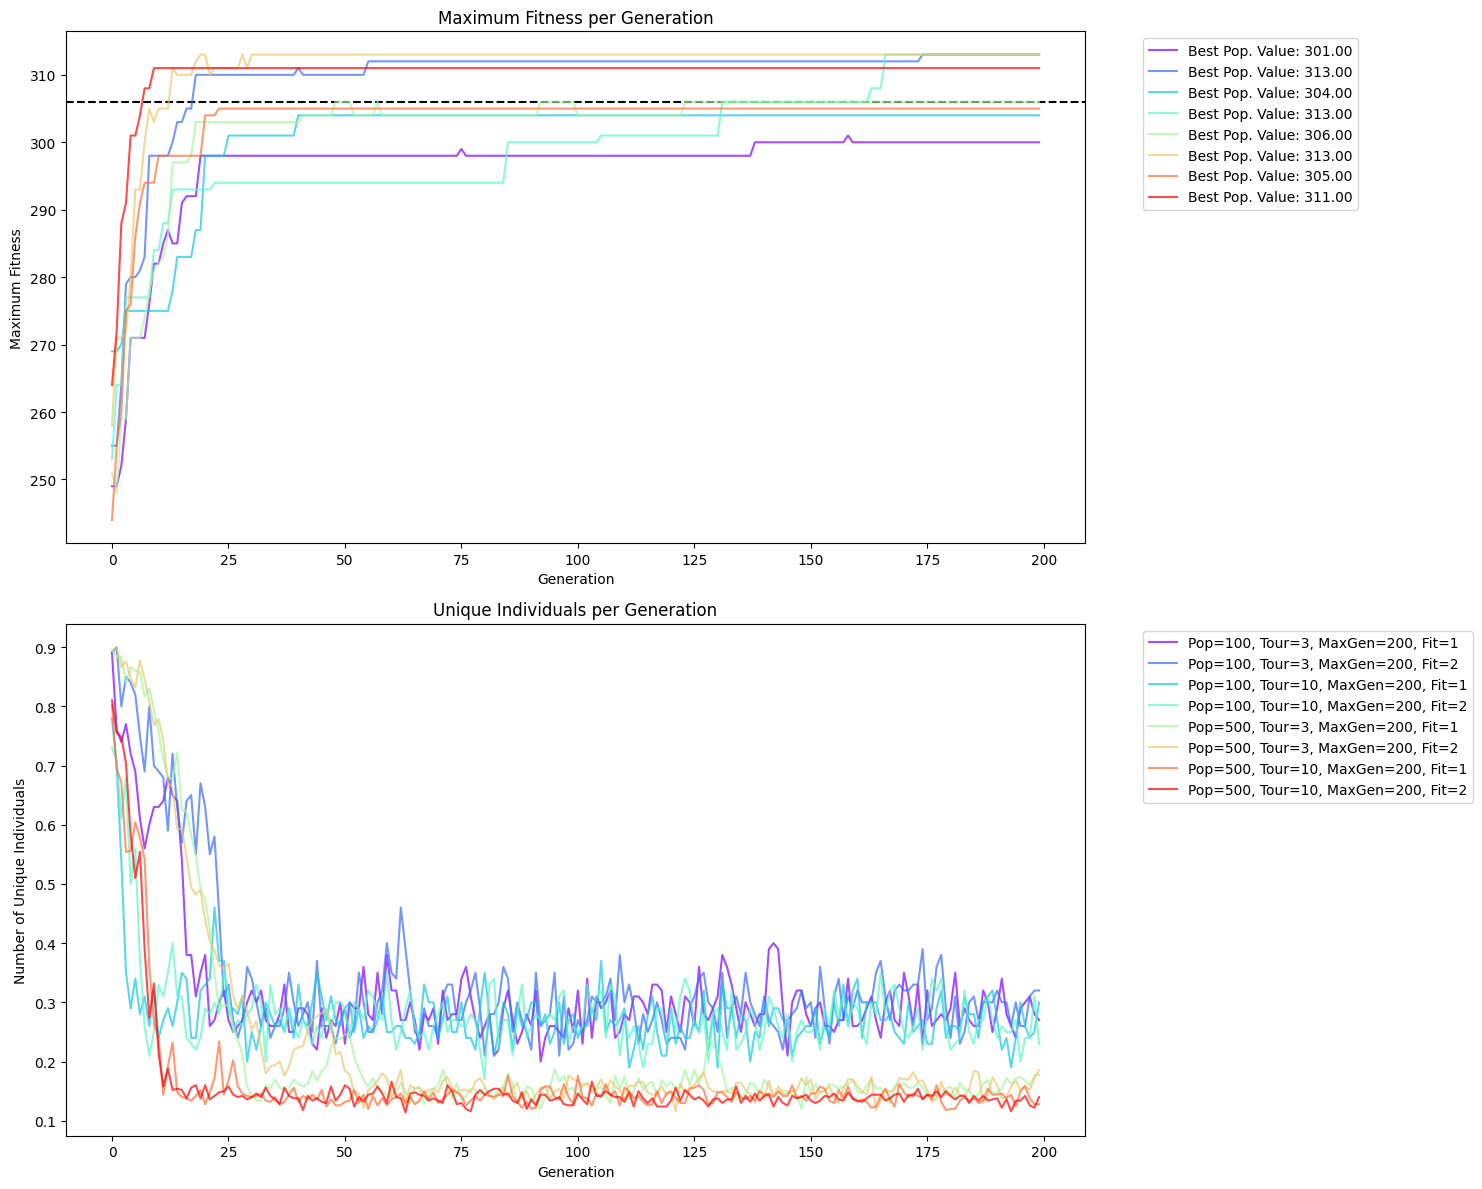

In [14]:
problem = parse_input_from_file("dataset")

max_value = knapsack_dp(problem)
results = run_experiment(problem)
plot_results(results, max_value = max_value)

## Sugestii de variere si evaluare
- Folosiți o funcție de mutatie cu probabilitate de mutatie per individ (nu per gena) si alegerea aleatoare a unei gene de mutat, in caz ca individul sufera mutatia
- Modificati procentajul de indivizi selectati prin procedura turneu
- Modificati metoda de statistici a populatiei pentru a obtine si valorile de fitness minim si mediu; modificati metoda de afisare pentru a plota si aceste statistici pe un grafic separat